In [1]:
import os, sys
import numpy as np
import json
from addict import Dict
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from astropy.visualization import MinMaxInterval, AsinhStretch, ImageNormalize
from baobab import bnn_priors
from baobab.configs import *
from h0rton.configs import TrainValConfig, TestConfig
from baobab.data_augmentation.noise_lenstronomy import NoiseModelNumpy
from h0rton.h0_inference import H0Posterior, plot_h0_histogram, h0_utils
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource

from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.util as util
import lenstronomy.Util.data_util as data_util

import baobab.sim_utils as sim_utils
from baobab.sim_utils import instantiate_PSF_models, get_PSF_model, Imager, Selection
from baobab.sim_utils import flux_utils, metadata_utils
from baobab.configs import BaobabConfig

import glob
import matplotlib.image as mpimg
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='STIXGeneral', size=20, weight='bold')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2, titlesize='large', labelsize='large', labelweight='bold')

#plt.rcParams['text.latex.preamble'] = [r'\boldmath']

In [32]:
true_H0 = 70.0
true_Om0 = 0.3
true_cosmo = FlatLambdaCDM(H0=true_H0, Om0=true_Om0)

In [58]:
baobab_log_path = glob.glob('/home/jwp/stage/sl/h0rton/v6_test_td_prior=DiagonalCosmoBNNPrior_seed=1111/log_*.json')[0]
with open(baobab_log_path, 'r') as f:
    log_str = f.read()
cfg = Dict(json.loads(log_str))
meta = pd.read_csv(os.path.abspath(os.path.join(cfg.out_dir, 'metadata.csv')), index_col=None)

img_files = [fname for fname in os.listdir(cfg.out_dir) if fname.endswith('.npy')]

In [59]:
default_version_id = 0
default_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(default_version_id)
test_cfg_path = os.path.join(default_version_dir, 'mcmc_default.json')
test_cfg = TestConfig.from_file(test_cfg_path)
train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)
noise_kwargs_default = train_val_cfg.data.noise_kwargs.copy()

In [60]:
summary = pd.read_csv(os.path.join(default_version_dir, 'summary.csv'), index_col=False, nrows=201)
metadata = pd.read_csv(os.path.join(os.path.dirname(baobab_log_path), 'metadata.csv'), index_col=False)
metadata['id'] = metadata.index

In [61]:
print(summary.columns, summary.shape, metadata.shape)
summary.drop([200], inplace=True)

Index(['Unnamed: 0', 'n_img', 'z_lens', 'z_src', 'id', 'D_dt_mu', 'D_dt_sigma',
       'H0_mean', 'H0_std', 'inference_time', 'D_dt_mean', 'D_dt_std'],
      dtype='object') (201, 12) (1000, 38)


In [62]:
print(summary.columns, summary.shape, metadata.shape)
summary = summary.merge(metadata, on='id', suffixes=['', '_meta'], how='inner')

Index(['Unnamed: 0', 'n_img', 'z_lens', 'z_src', 'id', 'D_dt_mu', 'D_dt_sigma',
       'H0_mean', 'H0_std', 'inference_time', 'D_dt_mean', 'D_dt_std'],
      dtype='object') (200, 12) (1000, 38)


In [63]:
print(summary.columns)

Index(['Unnamed: 0', 'n_img', 'z_lens', 'z_src', 'id', 'D_dt_mu', 'D_dt_sigma',
       'H0_mean', 'H0_std', 'inference_time', 'D_dt_mean', 'D_dt_std', 'H0',
       'agn_light_magnitude', 'external_shear_dec_0',
       'external_shear_gamma_ext', 'external_shear_psi_ext',
       'external_shear_ra_0', 'img_filename', 'kappa_ext',
       'lens_light_R_sersic', 'lens_light_center_x', 'lens_light_center_y',
       'lens_light_e1', 'lens_light_e2', 'lens_light_magnitude',
       'lens_light_n_sersic', 'lens_mass_center_x', 'lens_mass_center_y',
       'lens_mass_e1', 'lens_mass_e2', 'lens_mass_gamma', 'lens_mass_theta_E',
       'n_img_meta', 'psf_idx', 'src_light_R_sersic', 'src_light_center_x',
       'src_light_center_y', 'src_light_e1', 'src_light_e2',
       'src_light_magnitude', 'src_light_n_sersic', 'total_magnification',
       'true_td', 'true_vd', 'x_image', 'y_image', 'z_lens_meta',
       'z_src_meta'],
      dtype='object')


In [64]:
summary['lensed_E_ring_flux'] = 0.0
summary['lensed_E_ring_mag'] = 0.0

In [65]:
lens_mass_model = LensModel(lens_model_list=['PEMD', 'SHEAR_GAMMA_PSI'])
src_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
lens_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
ps_model = PointSource(point_source_type_list=['LENSED_POSITION'], fixed_magnification_list=[False])
components = ['lens_mass', 'src_light', 'agn_light', 'lens_light']
kwargs_detector = util.merge_dicts(cfg.instrument, cfg.bandpass, cfg.observation)
psf_models = instantiate_PSF_models(cfg.psf, cfg.instrument.pixel_scale)
psf_model = get_PSF_model(psf_models, 1, 0)
kwargs_detector.update(seeing=cfg.psf.fwhm, psf_type=cfg.psf.type, kernel_point_source=psf_model, background_noise=0.0)

for lens_i in range(200):
    imager = Imager(components, lens_mass_model, src_light_model, lens_light_model=lens_light_model, ps_model=ps_model, kwargs_numerics={'supersampling_factor': 1}, min_magnification=0.0, for_cosmography=True)
    imager._set_sim_api(num_pix=64, kwargs_detector=kwargs_detector)
    imager.kwargs_src_light = metadata_utils.get_kwargs_src_light(metadata.iloc[lens_i])
    imager.kwargs_src_light = flux_utils.mag_to_amp_extended(imager.kwargs_src_light, imager.src_light_model, imager.data_api)
    imager.kwargs_lens_mass = metadata_utils.get_kwargs_lens_mass(metadata.iloc[lens_i])
    sample_ps = metadata_utils.get_nested_ps(metadata.iloc[lens_i])
    imager.for_cosmography = False
    imager._load_agn_light_kwargs(sample_ps)
    lensed_total_flux, lensed_src_img = flux_utils.get_lensed_total_flux(imager.kwargs_lens_mass, imager.kwargs_src_light, None, imager.image_model, return_image=True)
    lensed_ring_total_flux = np.sum(lensed_src_img)
    summary.loc[lens_i, 'lensed_E_ring_flux'] = lensed_ring_total_flux
    summary.loc[lens_i, 'lensed_E_ring_mag'] = data_util.cps2magnitude(lensed_ring_total_flux, cfg.bandpass.magnitude_zero_point)

## Bin the Einstein ring brightness

In [66]:
print((summary['lensed_E_ring_mag'].max() - summary['lensed_E_ring_mag'].min()) / 4)
print((20.5 - 17)/4)
lensed_ring_bins = np.array([np.quantile(summary['lensed_E_ring_mag'].values, 0.25), np.quantile(summary['lensed_E_ring_mag'].values, 0.5), np.quantile(summary['lensed_E_ring_mag'].values, 0.75), summary['lensed_E_ring_mag'].max() + 0.1]) 
#lensed_ring_bins = np.array([18.0, 19.0, 20.0, 21.0])
print(lensed_ring_bins)

1.3940682180509736
0.875
[18.78556295 19.95069917 21.12733155 23.13023086]


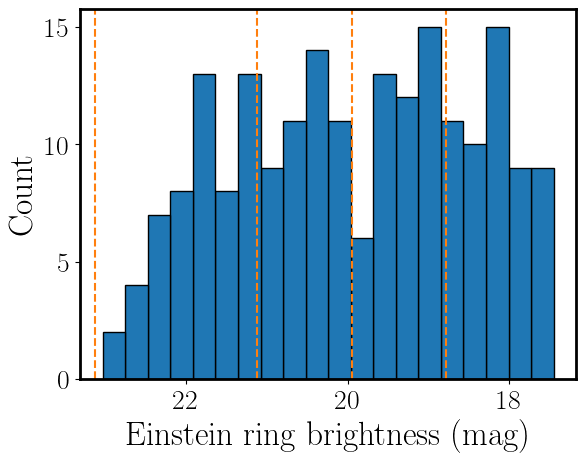

In [67]:
plt.close('all')
plt.hist(summary['lensed_E_ring_mag'], edgecolor='k', bins=20)
plt.gca().invert_xaxis()
for bin_edge in list(lensed_ring_bins):
    plt.axvline(bin_edge, color='tab:orange', linestyle='--')
plt.xlabel('Einstein ring brightness (mag)')
plt.ylabel('Count')
plt.show()

In [68]:
print("Testing digitize: ", np.digitize([18, 19, 20.5, 21.5], lensed_ring_bins)[:5])
summary['lensed_ring_bin'] = np.digitize(summary['lensed_E_ring_mag'].values, lensed_ring_bins)

Testing digitize:  [0 1 2 3]


In [69]:
lensed_ring_bin = summary['lensed_ring_bin'].values
# Check what bin high-g lenses are in
summary['g'] = ((summary['H0_mean'] - true_H0)/summary['H0_std'])**2.0
summary[summary['g']>4.0][['n_img', 'g', 'lensed_ring_bin']]

,n_img,g,lensed_ring_bin
3,4.0,4.049743,2
120,2.0,5.699175,2
183,4.0,4.132631,1
189,2.0,5.083606,1


In [45]:
for bin_i in range(len(lensed_ring_bins)):
    take_bin_i = (summary['lensed_ring_bin'] == bin_i)
    mcmc_samples, logL = h0_utils.combine_lenses(true_cosmo, summary['D_dt_mu'][take_bin_i].values, summary['D_dt_sigma'][take_bin_i].values, summary['z_lens'][take_bin_i].values, summary['z_src'][take_bin_i].values, samples_save_path=os.path.join(default_version_dir, f'combined_H0_ering_{bin_i}.npy'), corner_save_path='.', n_run=100, n_burn=500, n_walkers=20)
    plt.show()

  0%|          | 2/600 [00:00<04:50,  2.06it/s]Traceback (most recent call last):
  File "/home/jwp/miniconda3/envs/baobab/lib/python3.6/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/jwp/stage/sl/hierArc/hierarc/Likelihood/cosmo_likelihood.py", line 95, in likelihood
    logL = self._likelihoodLensSample.log_likelihood(cosmo=cosmo, kwargs_lens=kwargs_lens, kwargs_kin=kwargs_kin)
  File "/home/jwp/stage/sl/hierArc/hierarc/Likelihood/lens_sample_likelihood.py", line 29, in log_likelihood
    logL += lens.lens_log_likelihood(cosmo=cosmo, kwargs_lens=kwargs_lens, kwargs_kin=kwargs_kin)
  File "/home/jwp/stage/sl/hierArc/hierarc/Likelihood/hierarchy_likelihood.py", line 65, in lens_log_likelihood
    ddt, dd = self.angular_diameter_distances(cosmo)
  File "/home/jwp/stage/sl/hierArc/hierarc/Likelihood/hierarchy_likelihood.py", line 114, in angular_diameter_distances
    ds = cosmo.angular_diameter_distance(z=self._z_sou

emcee: Exception while calling your likelihood function:
  params: [65.46252508]
  args: ()
  kwargs: {}
  exception:


KeyboardInterrupt: 

## Combine precision ceiling

In [70]:
prec_version_id = 5
prec_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(prec_version_id)
assert default_version_dir != prec_dir

summary_prec = pd.read_csv(os.path.join(prec_dir, 'summary.csv'), index_col=False, nrows=200)
summary_prec = summary_prec.merge(metadata, on='id', suffixes=['', '_meta'], how='inner')
summary_prec['lensed_ring_bin'] = lensed_ring_bin

In [71]:
summary[summary['g']>4.0][['n_img', 'g', 'lensed_ring_bin']]

,n_img,g,lensed_ring_bin
3,4.0,4.049743,2
120,2.0,5.699175,2
183,4.0,4.132631,1
189,2.0,5.083606,1


In [19]:
for bin_i in range(len(lensed_ring_bins)):
    take_bin_i = (summary_prec['lensed_ring_bin'] == bin_i)
    mcmc_samples, logL = h0_utils.combine_lenses(true_cosmo, summary_prec['D_dt_mu'][take_bin_i].values, summary_prec['D_dt_sigma'][take_bin_i].values, summary_prec['z_lens'][take_bin_i].values, summary_prec['z_src'][take_bin_i].values, samples_save_path=os.path.join(prec_dir, f'combined_H0_ering_{bin_i}.npy'), corner_save_path='.', n_run=100, n_burn=500, n_walkers=20)
    plt.show()

  1%|          | 7/600 [00:03<04:53,  2.02it/s]Traceback (most recent call last):
  File "/home/jwp/miniconda3/envs/baobab/lib/python3.6/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/jwp/stage/sl/hierArc/hierarc/Likelihood/cosmo_likelihood.py", line 95, in likelihood
    logL = self._likelihoodLensSample.log_likelihood(cosmo=cosmo, kwargs_lens=kwargs_lens, kwargs_kin=kwargs_kin)
  File "/home/jwp/stage/sl/hierArc/hierarc/Likelihood/lens_sample_likelihood.py", line 29, in log_likelihood
    logL += lens.lens_log_likelihood(cosmo=cosmo, kwargs_lens=kwargs_lens, kwargs_kin=kwargs_kin)
  File "/home/jwp/stage/sl/hierArc/hierarc/Likelihood/hierarchy_likelihood.py", line 65, in lens_log_likelihood
    ddt, dd = self.angular_diameter_distances(cosmo)
  File "/home/jwp/stage/sl/hierArc/hierarc/Likelihood/hierarchy_likelihood.py", line 115, in angular_diameter_distances
    dds = cosmo.angular_diameter_distance_z1z2(z1=self

emcee: Exception while calling your likelihood function:
  params: [72.21336274]
  args: ()
  kwargs: {}
  exception:


KeyboardInterrupt: 

## Compare with gamma recovery

In [72]:
summary_pred = summary.copy()
print(summary_pred.columns)
summary_pred = sim_utils.add_g1g2_columns(summary_pred)

Index(['Unnamed: 0', 'n_img', 'z_lens', 'z_src', 'id', 'D_dt_mu', 'D_dt_sigma',
       'H0_mean', 'H0_std', 'inference_time', 'D_dt_mean', 'D_dt_std', 'H0',
       'agn_light_magnitude', 'external_shear_dec_0',
       'external_shear_gamma_ext', 'external_shear_psi_ext',
       'external_shear_ra_0', 'img_filename', 'kappa_ext',
       'lens_light_R_sersic', 'lens_light_center_x', 'lens_light_center_y',
       'lens_light_e1', 'lens_light_e2', 'lens_light_magnitude',
       'lens_light_n_sersic', 'lens_mass_center_x', 'lens_mass_center_y',
       'lens_mass_e1', 'lens_mass_e2', 'lens_mass_gamma', 'lens_mass_theta_E',
       'n_img_meta', 'psf_idx', 'src_light_R_sersic', 'src_light_center_x',
       'src_light_center_y', 'src_light_e1', 'src_light_e2',
       'src_light_magnitude', 'src_light_n_sersic', 'total_magnification',
       'true_td', 'true_vd', 'x_image', 'y_image', 'z_lens_meta', 'z_src_meta',
       'lensed_E_ring_flux', 'lensed_E_ring_mag', 'lensed_ring_bin', 'g'],
      dt

In [73]:
summary_pred['src_light_center_x'] -= summary_pred['lens_mass_center_x']
summary_pred['src_light_center_y'] -= summary_pred['lens_mass_center_y']

In [74]:
# Metadata external to BNN training
#metadata = pd.read_csv(os.path.join(test_cfg.data.test_dir, 'metadata.csv'), index_col=None)
# Read in truth and predicted parameters for the BNN
#truth = pd.read_csv('../dummy/Y_truth.csv', index_col=None)
samples = np.load('/home/jwp/stage/sl/h0rton/experiments/v0/mcmc_default_export_pred/samples.npy')


In [75]:
samples[200, :5, 0, 4]

array([2.17712784, 2.18478799, 2.19828176, 2.17946553, 2.18787289])

In [76]:
print(samples.shape) # [batch_size, n_walkers=n_dropout_samples, samples_per_dropout, Y_dim]
print(samples.transpose(0, 3, 1, 2).shape)
n_lenses = samples.shape[0]
mcmc_Y_dim = samples.shape[-1]
n_test = 200
samples = samples.transpose(0, 3, 1, 2).reshape([n_lenses, mcmc_Y_dim, -1])[:n_test]
print(samples.shape)
print(samples[0, 4, :5], train_val_cfg.data.Y_cols[4])
#reshape([200, len(train_val_cfg.data.Y_cols), -1])
pred_mean = np.mean(samples, axis=-1)
pred_std = np.std(samples, axis=-1)

(1000, 12, 50, 11)
(1000, 11, 12, 50)
(200, 11, 600)
[1.96225429 1.95436537 1.95498312 1.96350527 1.95790207] lens_mass_gamma


In [77]:
params_to_remove = ['lens_light_R_sersic'] #'src_light_R_sersic'] 
mcmc_Y_cols = [col for col in train_val_cfg.data.Y_cols if col not in params_to_remove]
pred_mean = pd.DataFrame(pred_mean, columns=mcmc_Y_cols)
pred_std = pd.DataFrame(pred_std, columns=mcmc_Y_cols)

In [78]:
import baobab.sim_utils as sim_utils
pred_mean = sim_utils.add_qphi_columns(pred_mean)
pred_mean = sim_utils.add_gamma_psi_ext_columns(pred_mean)

In [79]:
pred_mean.head()

,lens_mass_center_x,src_light_center_x,lens_mass_center_y,src_light_center_y,lens_mass_gamma,lens_mass_theta_E,lens_mass_e1,lens_mass_e2,external_shear_gamma1,external_shear_gamma2,src_light_R_sersic,lens_mass_q,lens_mass_phi,external_shear_gamma_ext,external_shear_psi_ext
0,-0.090849,0.042993,0.101116,-0.015183,1.960320,1.051206,-0.047902,-0.511455,0.000872,0.011597,0.296483,0.321271,-0.832091,0.011630,0.747875
1,0.030366,-0.090954,0.038655,0.103557,2.123256,1.036826,-0.065436,0.247647,-0.005557,0.018365,0.413420,0.592171,0.914562,0.019187,0.932302
2,-0.111015,-0.107022,0.081742,0.184067,1.963677,1.185688,-0.167634,-0.309910,0.005968,-0.001811,0.321775,0.478915,-1.033318,0.006237,-0.147285
3,-0.170161,0.041694,0.012789,0.078357,1.994643,1.071889,-0.428235,-0.139600,0.024418,0.000796,0.384155,0.378916,-1.413233,0.024431,0.016296
4,0.021097,-0.048745,0.054696,-0.003305,1.771761,1.124859,-0.076291,0.069468,0.002120,0.021893,0.336415,0.812940,1.201484,0.021996,0.737139


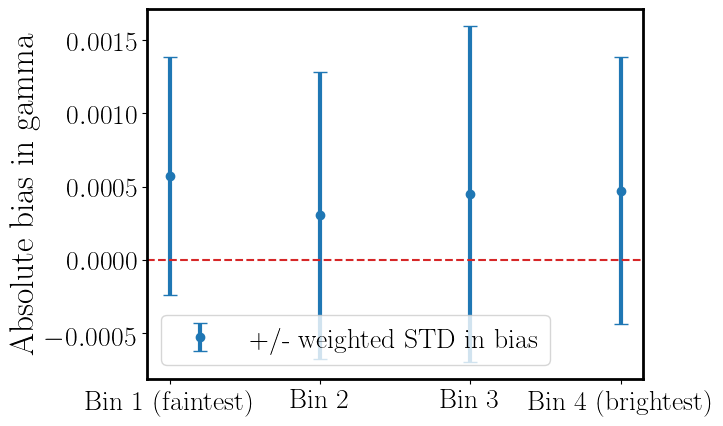

In [80]:
plt.close('all')
param_name = 'lens_mass_gamma'
param_label = 'gamma'

summary_pred['{:s}_bias'.format(param_name)] = pred_mean[param_name] - summary_pred[param_name]

plt.close('all')
centers = []
yerr_lower = []
yerr_upper = []
pm = []
for bin_i in range(4):
    binned = summary_pred[summary_pred['lensed_ring_bin']==bin_i]
    binned_std = pred_std[summary_pred['lensed_ring_bin']==bin_i]
    center = np.average(binned['{:s}_bias'.format(param_name)].values, weights=1.0/binned_std[param_name].values**2.0)
    weighted_std = np.average((binned['{:s}_bias'.format(param_name)].values - center)**2.0, weights=1.0/binned_std[param_name].values**2.0)**0.5
    #print(center, weighted_std)
    centers.append(center)
    pm.append(weighted_std)
    yerr_lower.append(center - weighted_std)
    yerr_upper.append(center + weighted_std)
labels = ['Bin 1 (faintest)', 'Bin 2', 'Bin 3', 'Bin 4 (brightest)']
plt.xticks(np.arange(4), labels=labels)
#print(centers, yerr_lower, yerr_upper)
plt.errorbar([3, 2, 1, 0], centers, yerr=pm, fmt='o', color='tab:blue', alpha=1.0, lw=3, capsize=5, label='+/- weighted STD in bias')
plt.axhline(0, c='tab:red', linestyle='--')
plt.ylabel('Absolute bias in {:s}'.format(param_label))
plt.legend()
plt.show()

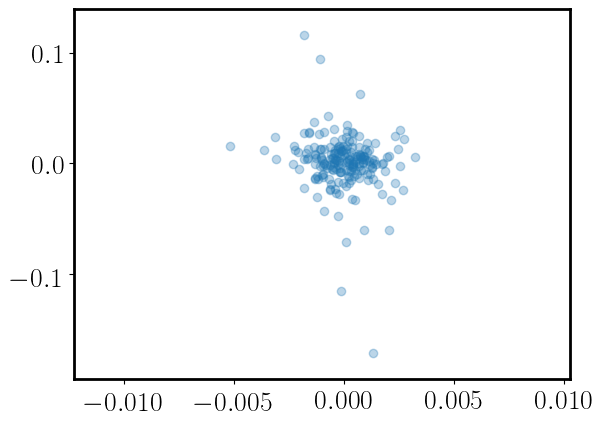

In [73]:
candidate_col = 'src_light_center_x'
plt.scatter(pred_mean[candidate_col] + pred_mean['lens_mass_center_x']- summary_pred[candidate_col] - summary_pred['lens_mass_center_x'], (summary_pred['H0_mean']- 70.0/(1 - summary_pred['kappa_ext']))/(70/1-summary_pred['kappa_ext']), alpha=0.3)
plt.show()

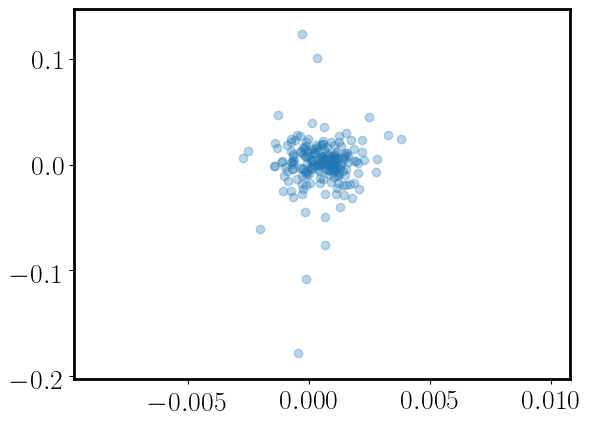

In [81]:
candidate_col = 'lens_mass_gamma'
plt.scatter(pred_mean[candidate_col]- summary_pred[candidate_col], (summary_pred['H0_mean']- 70.0/(1 - summary_pred['kappa_ext']))/(70/1-summary_pred['kappa_ext']), alpha=0.3)
plt.show()

(200, 11)


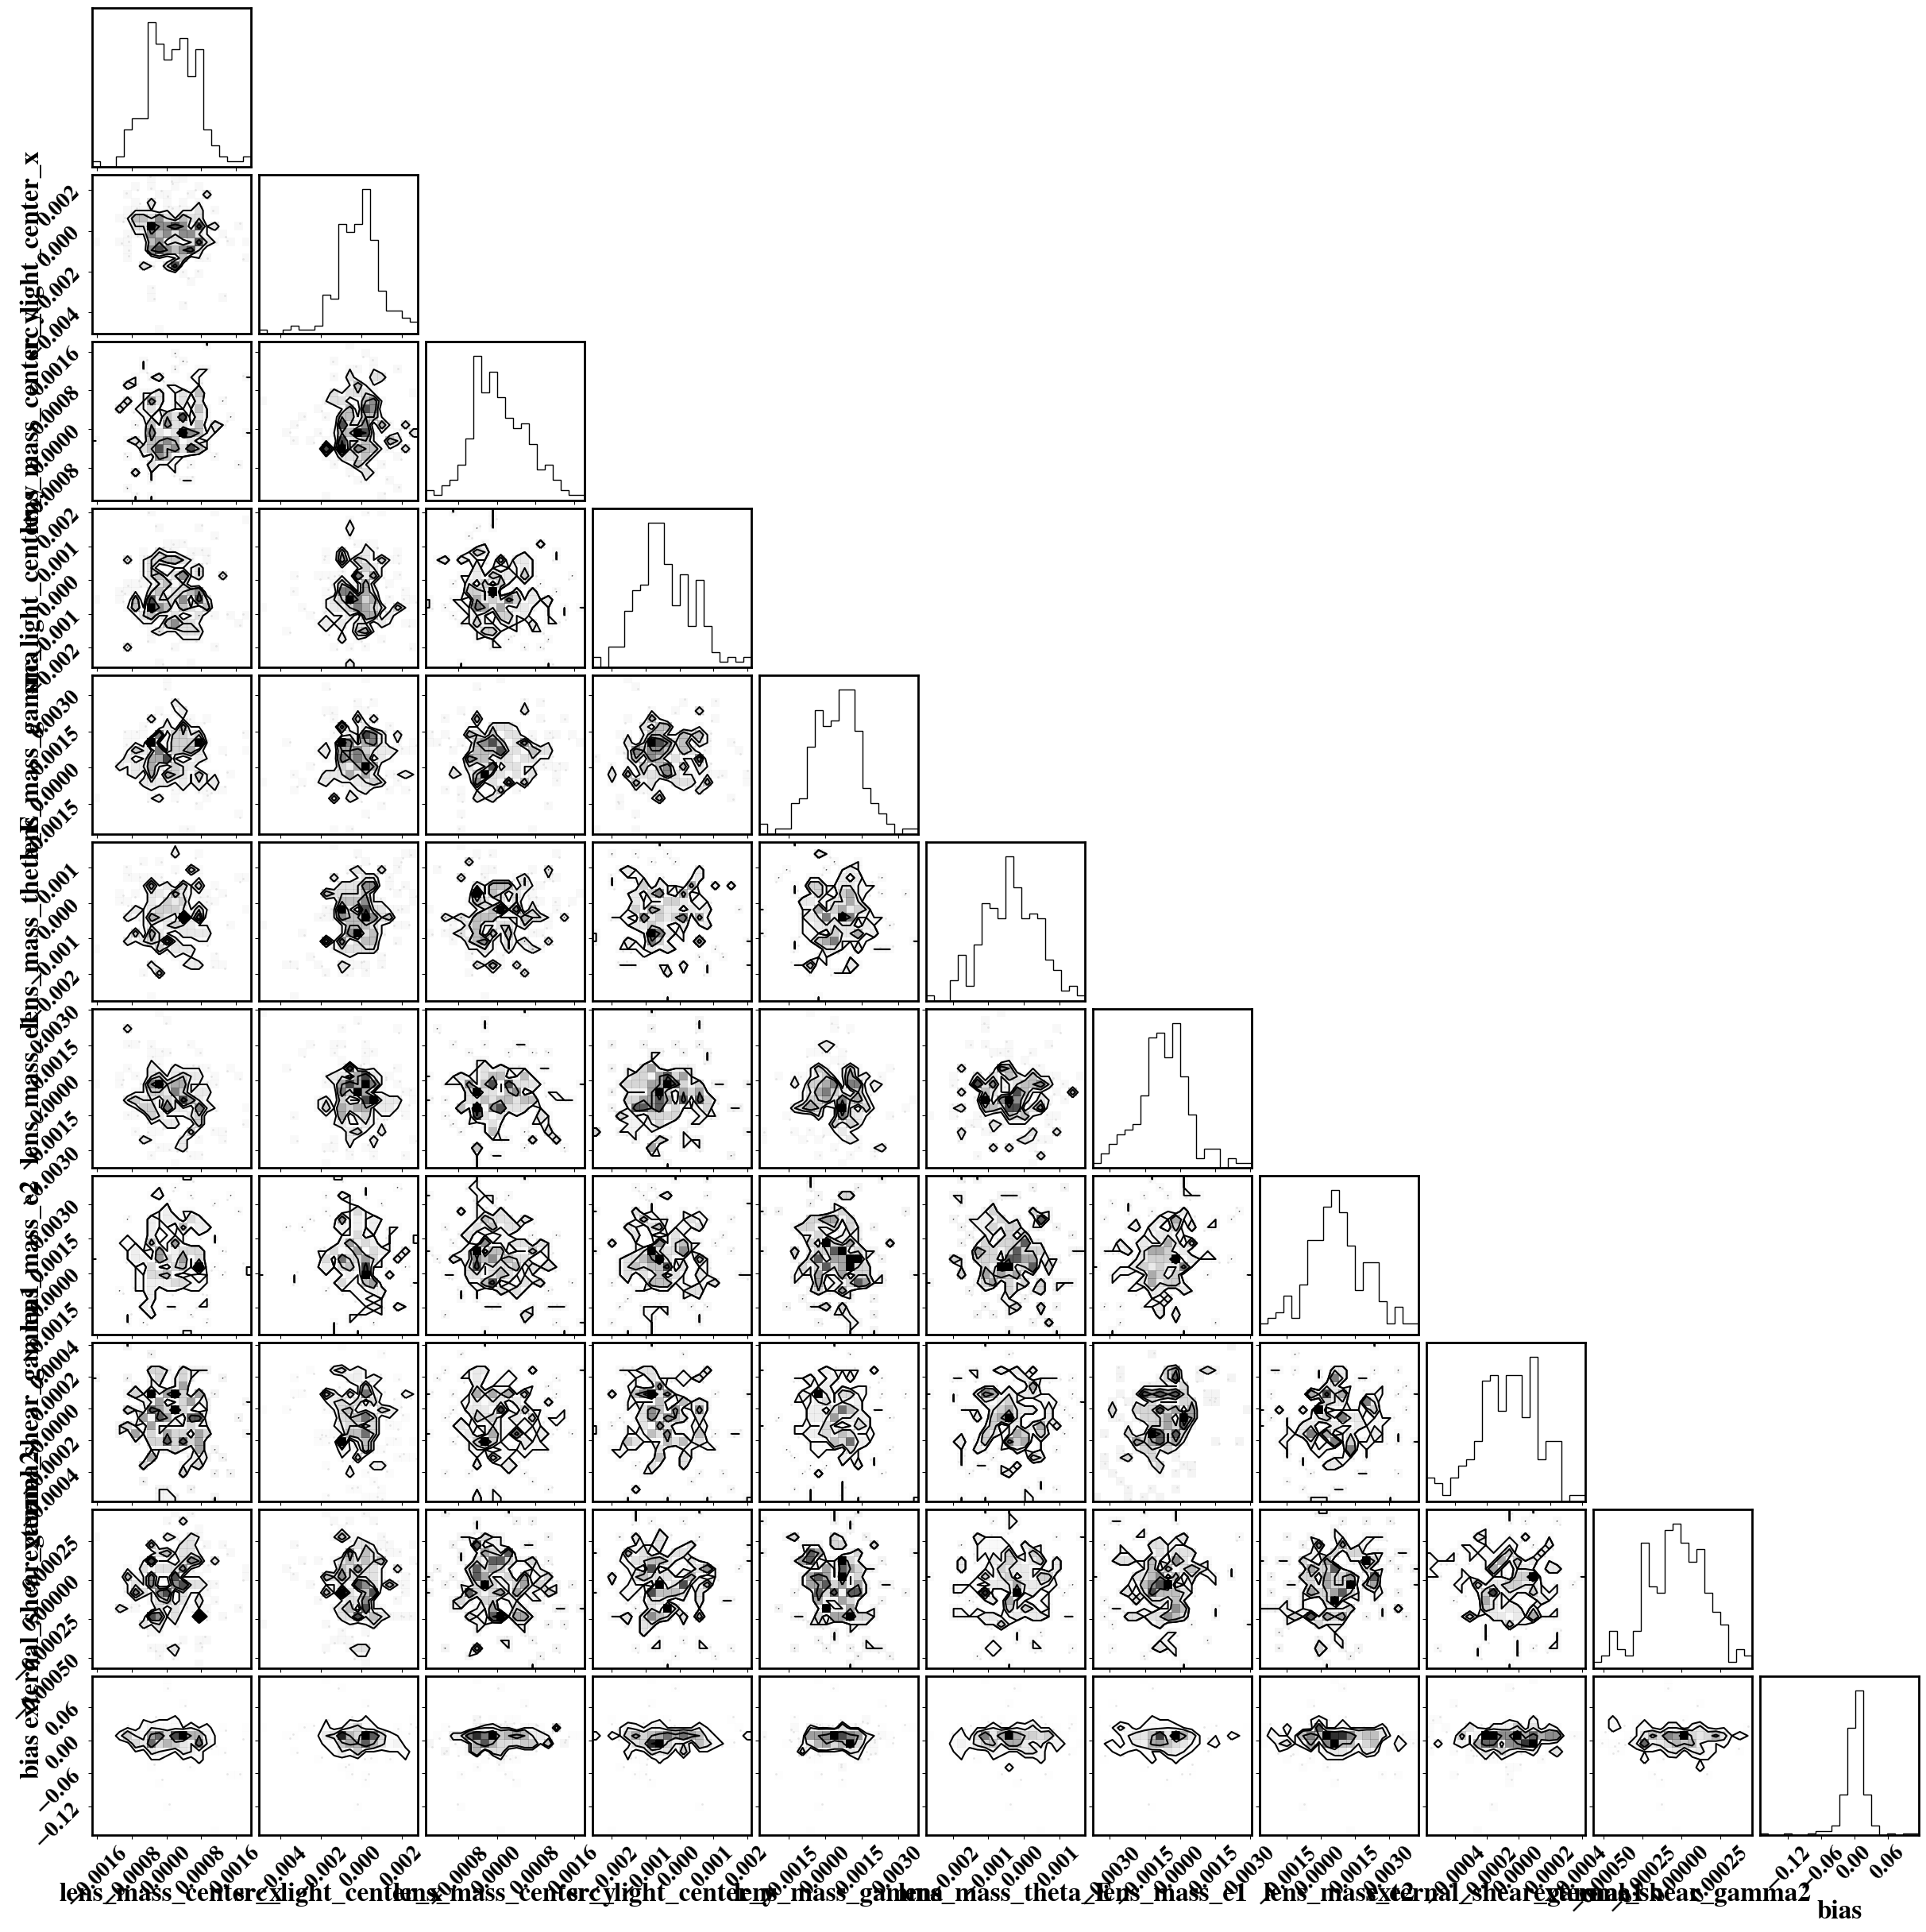

In [94]:
import corner
plt.rc('text', usetex=False)
candidate_cols = ['lens_mass_center_x', 'src_light_center_x', 'lens_mass_center_y', 'src_light_center_y', 'lens_mass_gamma', 'lens_mass_theta_E', 'lens_mass_e1', 'lens_mass_e2', 'external_shear_gamma1', 'external_shear_gamma2']
diff = pred_mean[candidate_cols] - summary_pred[candidate_cols]
diff['H0_bias'] = (summary_pred['H0_mean']- 70.0/(1 - summary_pred['kappa_ext']))/(70/1-summary_pred['kappa_ext']).values
print(diff.shape)
corner.corner(diff, 
              labels=candidate_cols + ['bias']
             )

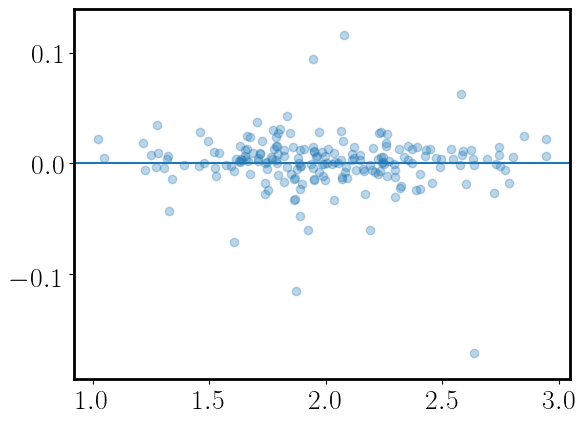

In [88]:
candidate_col = 'z_src'
plt.scatter(summary_pred[candidate_col], (summary_pred['H0_mean']- 70.0/(1 - summary_pred['kappa_ext']))/(70/1-summary_pred['kappa_ext']), alpha=0.3)
plt.axhline(0)
plt.show()

In [ ]:
candidate_cols = ['lens_mass_gamma', 'lens_mass_theta_E', 'lens_mass_e1', 'lens_mass_e2', 'lens_mass]

In [44]:
np.mean(np.abs(summary_pred['lens_mass_gamma_bias']))

0.0008737271838321148

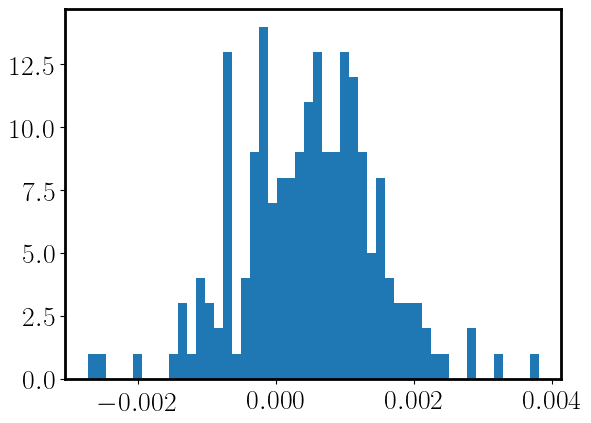

In [45]:
plt.close('all')
plt.hist(summary_pred['lens_mass_gamma_bias'], bins=50)
plt.show()

In [47]:
plt.close('all')
plt.hist(pred['gamma_bias'], bins=40)
plt.ylabel('Count')
plt.xlabel('Predicted - true gamma')
plt.show()

NameError: name 'pred' is not defined

In [ ]:
plt.close('all')
plt.hist(pred['frac_gamma_bias'], bins=40)
plt.ylabel('Count')
plt.xlabel('Fractional gamma bias = (predicted - true)/ true')
plt.show()

In [ ]:
centers = []
yerr_lower = []
yerr_upper = []
for bin_i in range(4):
    binned_bias = pred[pred['lensed_ring_bin']==bin_i]['frac_gamma_bias'].values
    center = np.mean(binned_bias)
    lower = np.quantile(binned_bias, q=0.5 - 0.341)
    upper = np.quantile(binned_bias, q=0.5 + 0.341)
    centers.append(center)
    yerr_lower.append(upper - center)
    yerr_upper.append(center - lower)

plt.xticks(np.arange(4), labels=labels)
plt.errorbar([3, 2, 1, 0], centers, yerr=[yerr_lower, yerr_upper], fmt='.', color='tab:blue', alpha=1.0, lw=3, capsize=5, label='68\% in BNN-predicted mean')
plt.axhline(0, c='tab:red', linestyle='--')
plt.ylabel('Fractional bias in gamma')
plt.legend()
plt.show()

In [ ]:
plt.scatter(pred['lensed_ring_bin'], pred['gamma_bias'], alpha=0.1)
plt.show()

## Plot

In [ ]:
[[]]*4

In [ ]:
# Read in inferred posteriors
orbits = dict(zip([0.5, 1, 2, 4], [0, 1, 2, 3]))
labels = ['Bin 1 (faintest)', 'Bin 2', 'Bin 3', 'Bin 4 (brightest)']
h0_pred = dict(zip(orbits, [[], [], [], []]))
for orbit_i, orbit in enumerate(orbits.keys()):
    version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(orbit_i)
    for label_i, l in enumerate(labels):
        h0_pred[orbit].append(np.load(os.path.join(version_dir, 'combined_H0_ering_{:d}.npy'.format([3, 2, 1, 0][label_i])), allow_pickle=True).squeeze())
    h0_pred[orbit] = np.array(h0_pred[orbit])

include_prec_floor = True

In [ ]:
prec_floor = []
if include_prec_floor:
    # Read in precision floor
    for i, l in enumerate(labels):
        prec_floor.append(np.load(os.path.join(prec_dir, 'combined_H0_ering_{:d}.npy'.format([3, 2, 1, 0][i])), allow_pickle=True).squeeze())
prec_floor = np.array(prec_floor)
print(prec_floor.shape)

In [ ]:
colors_dict = {0.5: '#E15759', 1:'#F28E2B', 2:'#59A14F', 4:'#4E79A7'} # tableau new
colors_dict = dict(zip([4, 2, 1, 0.5], ['#880519', '#b32c36', '#da5054', '#f97978']))

#colors_dict = dict(zip([0.5, 1, 2, 4],  ['#ffbcaf', '#f4777f', '#cf3759', '#93003a']))
seconds_dict = {0.5: '2,700s', 1:'5,400s', 2:'10,800s', 4:'21,600s'}

In [ ]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.close('all')
fig, ax = plt.subplots(figsize=(18, 8))
n_ering_bins = len(h0_pred[0.5])

# 1-sigma for each exptime
for orbit_i, orbit in enumerate(orbits.keys()):
    means = np.mean(h0_pred[orbit], axis=1)
    stds = np.std(h0_pred[orbit], axis=1)
    upper_sig = np.quantile(h0_pred[orbit], axis=1, q=0.5 + 0.341)
    lower_sig = np.quantile(h0_pred[orbit], axis=1, q=0.5 - 0.341)
    plt.errorbar(np.arange(n_ering_bins) + orbit_i*0.1 - 0.2, means, yerr=[upper_sig-means, means-lower_sig], fmt='o', color=colors_dict[orbit], lw=5, capsize=10, label='{:s}'.format(seconds_dict[orbit]))


#boxplot_legend_elements = [Line2D([0], [0], color='k', lw=2, label='this'), 
#                           Patch(facecolor='tab:blue', alpha=0.5, label='that')]
#boxplot_legend = plt.legend(handles=boxplot_legend_elements, loc='upper right')

if include_prec_floor:
    prec_floor_means = np.mean(prec_floor, axis=1)
    prec_floor_upper_sig = np.quantile(prec_floor, axis=1, q=0.5 + 0.341) 
    prec_floor_lower_sig = np.quantile(prec_floor, axis=1, q=0.5 - 0.341) 
    plt.errorbar(np.arange(n_ering_bins) + 0.2, prec_floor_means, yerr=[prec_floor_upper_sig-prec_floor_means, prec_floor_means-prec_floor_lower_sig], fmt='o', color='tab:gray', alpha=1.0, lw=3, capsize=5, label=r'Time delay precision ceiling')
    
# Axis labels, ticks
# x
plt.xticks(np.arange(4), labels=labels, fontsize=25)
plt.xlim([-0.5, len(labels) + -1 + 0.5])
# y
plt.yticks(np.arange(69, 71 + 1, 0.5), fontsize=25)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')
ax.grid(axis="y", color="black", which='minor', alpha=.2,  linestyle=(0, (1, 1)))
plt.ylim([69, 71])

plt.axhline(70.0, c='k', linestyle='--', label='Truth = 70 km Mpc$^{-1}$ s$^{-1}$')
plt.ylabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)", fontsize=30)
plt.xlabel("Brightness of the Einstein ring", fontsize=30)
#plt.ylabel("$H_0\:(\\textbf{km Mpc}^{-1}\:\\textbf{s}^{-1})$")
plt.legend(loc='lower right', ncol=3)
handles, legend_labels = plt.gca().get_legend_handles_labels()
print(handles, legend_labels)
order = [0, 5, 1, 2, 3, 4]
plt.legend([handles[idx] for idx in order], [legend_labels[idx] for idx in order], loc='upper left', fontsize=25, ncol=3)
plt.savefig('../boxplot_ering.png', bbox_inches='tight', pad_inches=0) #dpi=1200)
plt.show()

(2, 10000)
[<matplotlib.lines.Line2D object at 0x7fbd9145c358>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>] ['Truth = 70 km Mpc$^{-1}$ s$^{-1}$', '2,700s', 'Time delay precision ceiling']


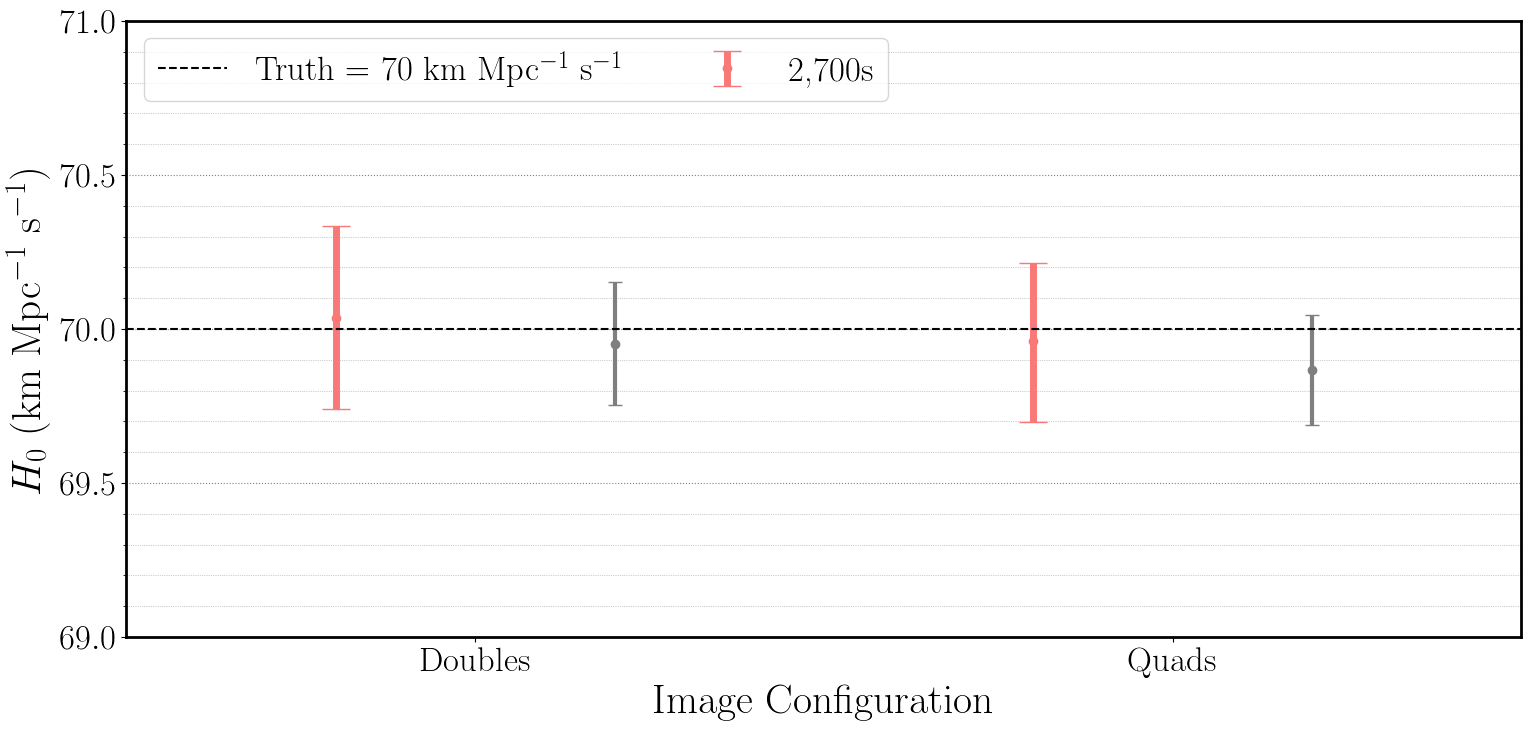

In [87]:
# Read in inferred posteriors
if False:
    labels = ['doubles', 'quads']
    h0_pred = []
    for l in labels:
        h0_pred.append(np.load('/home/jwp/stage/sl/h0rton/experiments/v{:d}/combined_H0_{:s}.npy'.format(version_id, l), allow_pickle=True).squeeze())
    h0_pred = np.array(h0_pred)
    print(h0_pred.shape)

# Read in inferred posteriors
orbits = dict(zip([0.5], [8]))
labels = ['doubles', 'quads']
h0_pred = dict(zip(orbits, [[], [], [], []]))
for orbit_i, orbit in enumerate(orbits.keys()):
    version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(8)
    for label_i, l in enumerate(labels):
        h0_pred[orbit].append(np.load(os.path.join(version_dir, 'combined_H0_{:s}.npy'.format(l)), allow_pickle=True).squeeze())
    h0_pred[orbit] = np.array(h0_pred[orbit])

include_prec_floor = True

# Read in precision floor
labels = ['doubles', 'quads']
prec_floor = []
for l in labels:
    prec_floor.append(np.load('/home/jwp/stage/sl/h0rton/experiments/v{:d}/combined_H0_{:s}.npy'.format(5, l), allow_pickle=True).squeeze())
prec_floor = np.array(prec_floor)
print(prec_floor.shape)

colors_dict = dict(zip([4, 2, 1, 0.5], ['#880519', '#b32c36', '#da5054', '#f97978']))

#colors_dict = dict(zip([0.5, 1, 2, 4],  ['#ffbcaf', '#f4777f', '#cf3759', '#93003a']))
seconds_dict = {0.5: '2,700s', 1:'5,400s', 2:'10,800s', 4:'21,600s'}

from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.close('all')
fig, ax = plt.subplots(figsize=(18, 8))
n_bins = len(labels)

# 1-sigma for each exptime
for orbit_i, orbit in enumerate(orbits.keys()):
    means = np.mean(h0_pred[orbit], axis=1)
    stds = np.std(h0_pred[orbit], axis=1)
    upper_sig = np.quantile(h0_pred[orbit], axis=1, q=0.5 + 0.341)
    lower_sig = np.quantile(h0_pred[orbit], axis=1, q=0.5 - 0.341)
    plt.errorbar(np.arange(n_bins) + orbit_i*0.1 - 0.2, means, yerr=[upper_sig-means, means-lower_sig], fmt='o', color=colors_dict[orbit], lw=5, capsize=10, label='{:s}'.format(seconds_dict[orbit]))


#boxplot_legend_elements = [Line2D([0], [0], color='k', lw=2, label='this'), 
#                           Patch(facecolor='tab:blue', alpha=0.5, label='that')]
#boxplot_legend = plt.legend(handles=boxplot_legend_elements, loc='upper right')

if include_prec_floor:
    prec_floor_means = np.mean(prec_floor, axis=1)
    prec_floor_upper_sig = np.quantile(prec_floor, axis=1, q=0.5 + 0.341) 
    prec_floor_lower_sig = np.quantile(prec_floor, axis=1, q=0.5 - 0.341) 
    plt.errorbar(np.arange(n_bins) + 0.2, prec_floor_means, yerr=[prec_floor_upper_sig-prec_floor_means, prec_floor_means-prec_floor_lower_sig], fmt='o', color='tab:gray', alpha=1.0, lw=3, capsize=5, label=r'Time delay precision ceiling')
    
# Axis labels, ticks
xlabels = ['Doubles', 'Quads']
plt.xticks(np.arange(n_bins), labels=xlabels, fontsize=25)
plt.xlim([-0.5, len(labels) + -1 + 0.5])
# y
plt.yticks(np.arange(69, 71 + 1, 0.5), fontsize=25)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="y", color="black", alpha=.5,  linestyle='dotted')
ax.grid(axis="y", color="black", which='minor', alpha=.2,  linestyle=(0, (1, 1)))
plt.ylim([69, 71])

plt.axhline(70.0, c='k', linestyle='--', label='Truth = 70 km Mpc$^{-1}$ s$^{-1}$')
plt.ylabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)", fontsize=30)
plt.xlabel("Image Configuration", fontsize=30)
#plt.ylabel("$H_0\:(\\textbf{km Mpc}^{-1}\:\\textbf{s}^{-1})$")
plt.legend(loc='lower right', ncol=3)
handles, legend_labels = plt.gca().get_legend_handles_labels()
print(handles, legend_labels)
order = [0, 1]
plt.legend([handles[idx] for idx in order], [legend_labels[idx] for idx in order], loc='upper left', fontsize=25, ncol=3)
plt.savefig('../boxplot_doubles_vs_quads.png', bbox_inches='tight', pad_inches=0) #dpi=1200)
plt.show()